# Fashion Assistant

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Mon May 29 19:34:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install -q ultralytics
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.9 MB/s eta 0:00:00


## Download YOLOv8 model weights

In [ ]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TYZCjuV2u1ipkkgx6I-eeKfXeN1ardsX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TYZCjuV2u1ipkkgx6I-eeKfXeN1ardsX" -O fashion-assistant-segmentation-v1.pt && rm -rf /tmp/cookies.txt

/content
--2023-05-29 19:24:02--  https://docs.google.com/uc?export=download&confirm=t&id=1TYZCjuV2u1ipkkgx6I-eeKfXeN1ardsX
Resolving docs.google.com (docs.google.com)... 74.125.200.139, 74.125.200.101, 74.125.200.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ukju135tq61l9vi2rge82vv3v0jkhq1l/1685388225000/04309230031174164349/*/1TYZCjuV2u1ipkkgx6I-eeKfXeN1ardsX?e=download&uuid=3c7397d5-6c14-4a85-af66-74a9e1ae9d77 [following]
--2023-05-29 19:24:02--  https://doc-14-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ukju135tq61l9vi2rge82vv3v0jkhq1l/1685388225000/04309230031174164349/*/1TYZCjuV2u1ipkkgx6I-eeKfXeN1ardsX?e=download&uuid=3c7397d5-6c14-4a85-af66-74a9e1ae9d77
Resolving doc-14-ag-docs.googleusercontent.com (doc-14-ag-docs.googleusercontent.com)... 74.125.

In [ ]:
YOLO_CHECKPOINT_PATH = f'{HOME}/fashion-assistant-segmentation-v1.pt'
INPUT_IMAGE_PATH = f'{HOME}/photo_2023-05-29 19.50.58.jpeg'

In [ ]:
from ultralytics import YOLO

model = YOLO(YOLO_CHECKPOINT_PATH)

In [26]:
import cv2
import numpy as np
import supervision as sv


def from_yolov8(yolov8_results) -> sv.Detections:
    mask_maps = None
    if yolov8_results.masks:
        orig_shape = yolov8_results.orig_shape
        inference_shape = tuple(yolov8_results.masks.data.shape[1:])
        masks = yolov8_results.masks.data.cpu().numpy()
        # calculate pad and gain
        pad = (0, 0)
        gain = 0
        if inference_shape != orig_shape:
            gain = min(inference_shape[0] / orig_shape[0], inference_shape[1] / orig_shape[1])  # gain  = old / new
            pad = (inference_shape[1] - orig_shape[1] * gain) / 2, (inference_shape[0] - orig_shape[0] * gain) / 2

        top, left = int(pad[1]), int(pad[0])  # y, x
        bottom, right = int(inference_shape[0] - pad[1]), int(inference_shape[1] - pad[0])

        mask_maps = []
        for i in range(masks.shape[0]):
            mask = masks[i]
            mask = mask[top:bottom, left:right]
            mask = cv2.resize(mask, (orig_shape[1], orig_shape[0]))
            mask_maps.append(mask)
        mask_maps = np.asarray(mask_maps, dtype=bool)
    return sv.Detections(
        xyxy=yolov8_results.boxes.xyxy.cpu().numpy(),
        confidence=yolov8_results.boxes.conf.cpu().numpy(),
        class_id=yolov8_results.boxes.cls.cpu().numpy().astype(int),
        mask=mask_maps
    )

In [36]:
import numpy as np
import supervision as sv

def average_color_under_mask(image: np.array, mask: np.array) -> sv.Color:
    masked_pixels = image[mask]
    average_color = masked_pixels.mean(axis=0)
    return sv.Color(
        r=int(average_color[2]),
        g=int(average_color[1]),
        b=int(average_color[0]),
    )

In [39]:
import cv2
import supervision as sv

image = cv2.imread(INPUT_IMAGE_PATH)
result = model.predict(source=image, conf=0.25)[0]
detections = from_yolov8(result)
average_color = average_color_under_mask(image=image, mask=detections.mask[0])


0: 736x960 1 sweatshirt, 129.0ms
Speed: 10.2ms preprocess, 129.0ms inference, 5.1ms postprocess per image at shape (1, 3, 960, 960)


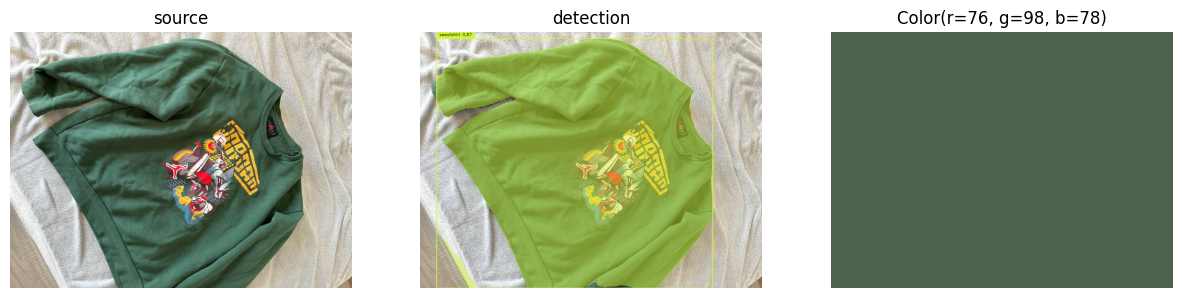

In [43]:
import numpy as np
import supervision as sv

image_height, image_width, _ = image.shape

box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

labels = [
    f"{model.model.names[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]
annotated_frame = box_annotator.annotate(
    scene=image.copy(),
    detections=detections,
    labels=labels
)
annotated_frame = mask_annotator.annotate(
    scene=annotated_frame,
    detections=detections
)

average_color_vizualization = np.zeros_like(image)
average_color_vizualization = sv.draw_filled_rectangle(
    scene=average_color_vizualization, 
    rect=sv.Rect(x=0, y=0, width=image_width, height=image_height),
    color=average_color
)

images = [image, annotated_frame, average_color_vizualization]
titles = ['source', 'detection', str(average_color)]

sv.plot_images_grid(images, grid_size=(1, 3), titles=titles, size=(15, 5))